In this notebook the eQTLs and pQTLs indentified with statistical package MatrixEQTL are analysed with respect to the network of protein-protein interactions in yeast.

In [1]:
%matplotlib inline

# utilities
import gc
import time
import os

import collections
import itertools
from importlib import reload
import pickle

# data analysis tools
import joblib
import random
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.sandbox.stats.multicomp import multipletests
from tqdm import *

tqdm.monitor_interval = 0

# network analysis tools
import igraph as ig

# multiprocessing tools
import subprocess
import multiprocessing as mp

os.chdir("{}/Science/eQTL_analysis/".format(os.environ["HOME"]))

# visualization tools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import networks
import qtls
import util
import ontologies

gc.enable()

%autosave 15

Autosaving every 15 seconds


## Datasets used

Take a look at readme.md in /data folder for data description. (currently unavailable)

In [2]:
random.seed(int(time.time()))

# 112 segregants genotyped by inherited marker variants
full_genotypes_df = pd.read_table("./data/genotypes/processed_genotypes.csv")

''' Where possible, gene names were converted from systematic to standard notation '''
# mRNA expression and genotypes of strains the data is available for
eQTLs_expression_df = pd.read_table("./data/eQTLs/expression.csv")
eQTLs_genotypes_df = pd.read_table("./data/eQTLs/genotypes.csv")
# Protein expression and genotypes of strains the data is available for 
pQTLs_expression_df = pd.read_table("./data/pQTLs/expression.csv")
pQTLs_genotypes_df = pd.read_table("./data/pQTLs/genotypes.csv")

# QTLs estimated with MatrixEQTL package for R
eQTLs_df = pd.read_table("./data/eQTLs/qtls.csv").query("q_value <= 0.05")
# eQTLs_df = pd.read_table("./data/eQTLs/qtls_2018.csv")#.query("q_value <= 0.05")
# eQTLs_df["gene"] = eQTLs_df["gene"].apply(networks.convert_to_std)
pQTLs_df = pd.read_table("./data/pQTLs/qtls.csv").query("q_value <= 0.05")

# Physical and genetic interactions taken from TheBioGrid project
full_interactome_df = pd.read_table("./data/interactions/yeast_interactome.csv")
# full_interactome_df = full_interactome_df[full_interactome_df['Publication year'] <= 2011]

genetic_interaction_categories = [
    "additive genetic interaction defined by inequality",
    "suppressive genetic interaction defined by inequality",
    "synthetic genetic interaction defined by inequality"
]
physical_interaction_categories = [
    "association",
    "colocalization",   
    "direct interaction",
    "physical association"
]

interaction_categories = genetic_interaction_categories + physical_interaction_categories
interactome_df = full_interactome_df.copy()
interactome_df.set_index('Interaction Type', inplace=True)
genetic_interactions_df = interactome_df[
    interactome_df.index.isin(genetic_interaction_categories)
]
physical_interactions_df = interactome_df[
    interactome_df.index.isin(physical_interaction_categories)
]

def extract_interactions(interactions_df):
    ''' Helper function to retrieve the edges of the graph of interactions '''
    return interactions_df[["Interactor A", "Interactor B"]].values

interactome_graphs_dict = {}
for category_name in interaction_categories + ["all", "genetic", "physical"]:
    with open("./data/interactions/{}_interactions_graph.pkl".format(category_name), "rb") as pickle_file:
        interactome_graphs_dict[category_name] = pickle.load(pickle_file)
interactome_graph = interactome_graphs_dict["physical"]

## Introduction and problem formulation

It seems rational to suppose that transcription and translation levels must be controlled by similar genetic mechanisms.  
Unfortunately, at the first sight there is no evidence to support that intuition: sets of eQTLs and pQTLs linked to given gene show no significant overlap for almost all genes. This is illustrated by the histogram below.

In [26]:
reload(util)
gene_pool = np.intersect1d(eQTLs_expression_df["gene"], pQTLs_expression_df["gene"])

linkage_overlap_data = []
for gene_name in gene_pool:
    linked_eQTLs = qtls.linked_markers(eQTLs_df, [gene_name])
    linked_pQTLs = qtls.linked_markers(pQTLs_df, [gene_name])
    linkage_overlap_data.append(qtls.jaccard(set(linked_eQTLs), set(linked_pQTLs)))

qtls.qtl_overlap_hist(linkage_overlap_data, "eQTLs_pQTLs")


Hypothesis arises: maybe not single genes, but functional modules tend to share linkages.  
The goal of this work is to test that hypothesis using yeast interactome data.

## Module processing

## Predicting pQTLs from eQTLs using PPI networks

Now, when approach using interaction networks is justified, it's time to provide solid ground: if significant fraction of pQTLs can be rediscovered from eQTLs linked to genes interacting with given (including itself), it will serve as an additional evidence for hypothesis being actually true (once again, no sophisticated clustering was performed here, while it would possibly yield better results).  

The main idea is not to test all (marker, gene) pairs but to filter for trusted only. In order to get rid of the pairs that will not link (or at least to dump more false than real linkages), the following approach is proposed: 
1. For each gene with measured protein abundance select its eQTL linkages as candidates into pQTLs. 
2. Extend eQTL linkages with those of the interacting genes. 

FDR decreases for the same q-value threshold, which results in more trustworthy observations.

Here is some statistics computed from some subgraphs of the interactome. 

**Physical interactions only**:   
- Common linkages: 2021, 32.7977929243752%
- Old linkages, total: 6162
- New linkages, total: 4048
- New linkages found: 2027

**Full interactome**:
- Common linkages: 3688, 59.85069782538137%
- Old linkages, total: 6162
- New linkages, total: 6219
- New linkages found: 2531

It becomes evident, that a significant fraction of estimated pQTLs can be reproduced using this approach.  
**Nevertheless, many questions arise**:
- Which fraction of trans-pQTLs is reproduced? (and is this approach capable of detecting those)
- Are all the hotspots reproduced? If some are not, why then? It is worth mentioning, that some of those were given cryptic names which are nowhere to be found. 
- How robust the results are? So far results are not compared with those computed from simulated, perturbed graphs. 

In [77]:
modules_type = "thebiogrid"
with open("./results/{}/modules_dict.pkl".format(modules_type), "rb") as pickle_file:
    modules_dict = pickle.load(pickle_file)
fdr_cutoffs = np.logspace(-5, -2, 10)

In [13]:
%%time

for simplify_flag in [False, True]:
    modules_stats = networks.basic_module_info(
         interactome_graph=interactome_graph, 
         modules_dict=modules_dict, 
         modules_type=modules_type,
         simplify=simplify_flag)
    modules_stats.to_csv("./results/{}/".format(modules_type) 
              + ("simplified" if simplify_flag else "raw") 
              + "_module_stats.csv", sep='\t', index=False)
    display(modules_stats.sort_values(by="genes_count", ascending=False))

,module_name,genes_count,genes_with_interactions,interactions_count
6,Mitosis & chromosome segregation,199,149,2478
12,"Glycosylation, protein folding|targeting, cell...",160,140,549
5,"Respiration, oxidative phosphorylation, mitoch...",138,135,318
15,Transcription & chromatin organization,110,85,1575
3,Cell polarity & morphogenesis,102,64,966
14,mRNA & tRNA processing,96,84,1126
4,Vesicle traffic,95,84,770
7,DNA replication & repair,95,75,926
0,rDNA & ncDNA processing,90,76,1055
13,Ribosome biogenesis,74,70,65


,module_name,genes_count,genes_with_interactions,interactions_count
6,Mitosis & chromosome segregation,199,145,667
12,"Glycosylation, protein folding|targeting, cell...",160,96,185
5,"Respiration, oxidative phosphorylation, mitoch...",138,88,165
15,Transcription & chromatin organization,110,81,303
3,Cell polarity & morphogenesis,102,60,225
14,mRNA & tRNA processing,96,80,456
4,Vesicle traffic,95,73,169
7,DNA replication & repair,95,71,183
0,rDNA & ncDNA processing,90,68,424
13,Ribosome biogenesis,74,35,45


CPU times: user 8.65 s, sys: 16 ms, total: 8.66 s
Wall time: 9.33 s


In [36]:
gene_pool = np.intersect1d(eQTLs_expression_df["gene"], pQTLs_expression_df["gene"])

In [56]:
jacc = []
for _ in range(1000):
    gene_set = np.random.RandomState().choice(gene_pool, 10, replace=False)
    linked_eQTLs = qtls.linked_markers(eQTLs_df, gene_set)
    linked_pQTLs = qtls.linked_markers(pQTLs_df, gene_set)
    jacc.append(qtls.jaccard(set(linked_eQTLs), set(linked_pQTLs)))
print(np.mean(jacc), np.median(jacc))

0.05317220280074159 0.0


In [47]:
%%time
reload(qtls)
display(
    pd.DataFrame(
        [
            (q_cutoff, *qtls.qtl_overlap_test(eQTLs_df.query("q_value < {}".format(q_cutoff)), 
                                              pQTLs_df.query("q_value < {}".format(q_cutoff)), 
                                              gene_pool, modules_dict))
            for q_cutoff in 10.**np.arange(-8, -1)
        ],
        columns = ["q_value_cutoff", "real_modules", "random_modules"],
        dtype=np.float32
    )
)

,q_value_cutoff,real_modules,random_modules
0,1.000000e-08,0.474820,0.146880
1,1.000000e-07,0.402913,0.162009
2,1.000000e-06,0.353571,0.169131
3,1.000000e-05,0.373563,0.193008
4,1.000000e-04,0.381375,0.228404
5,1.000000e-03,0.339683,0.263543
6,1.000000e-02,0.399551,0.340737


CPU times: user 1min 53s, sys: 80 ms, total: 1min 53s
Wall time: 1min 53s


In [46]:
sample_size = 50
def randomize_and_overlap(sample_size):
    jaccard_coeffs = []
    for i in range(200):
        gene_sample = np.random.RandomState().choice(gene_pool, sample_size, replace=False)
        linked_eQTLs = set(qtls.linked_markers(eQTLs_df, gene_sample))
        linked_pQTLs = set(qtls.linked_markers(pQTLs_df, gene_sample))
        jaccard_coeffs.append(qtls.jaccard(linked_eQTLs, linked_pQTLs))
    return np.mean(jaccard_coeffs)

display(
    pd.DataFrame(
        [
            (q_cutoff, randomize_and_overlap(sample_size))
            for q_cutoff in 10.**np.arange(-8, -1)
        ],
        columns = ["q_value_cutoff", "random_samples_of_size_{}".format(sample_size)],
        dtype=np.float32
    )
)

,q_value_cutoff,random_samples_of_size_50
0,1.000000e-08,0.289873
1,1.000000e-07,0.303140
2,1.000000e-06,0.304448
3,1.000000e-05,0.290948
4,1.000000e-04,0.281751
5,1.000000e-03,0.292801
6,1.000000e-02,0.290418


In [6]:
%%time

intersection_j, randomized_intersection_j = \
    qtls.qtl_overlap_by_module_test(eQTLs_df, pQTLs_df, gene_pool, modules_dict)

qtls.qtl_overlap_hist(intersection_j, modules_type)
qtls.qtl_overlap_hist(randomized_intersection_j, modules_type + "_randomized")

random samples generated:   0%|          | 0/108 [00:00<?, ?it/s]

random samples generated:   1%|          | 1/108 [00:00<00:31,  3.38it/s]

random samples generated:   2%|▏         | 2/108 [00:00<00:30,  3.53it/s]

random samples generated:   3%|▎         | 3/108 [00:00<00:29,  3.53it/s]

random samples generated:   4%|▎         | 4/108 [00:01<00:29,  3.49it/s]

random samples generated:   5%|▍         | 5/108 [00:01<00:30,  3.34it/s]

random samples generated:   6%|▌         | 6/108 [00:01<00:31,  3.25it/s]

random samples generated:   6%|▋         | 7/108 [00:02<00:30,  3.28it/s]

random samples generated:   7%|▋         | 8/108 [00:02<00:32,  3.11it/s]

random samples generated:   8%|▊         | 9/108 [00:02<00:31,  3.14it/s]

random samples generated:   9%|▉         | 10/108 [00:03<00:30,  3.17it/s]

random samples generated:  10%|█         | 11/108 [00:03<00:30,  3.20it/s]

random samples generated:  11%|█         | 12/108 [00:03<00:30,  3.10it/s]

random samples generated:  12%|█▏        | 13/108 [00:04<00:30,  3.10it/s]

random samples generated:  13%|█▎        | 14/108 [00:04<00:30,  3.11it/s]

random samples generated:  14%|█▍        | 15/108 [00:04<00:29,  3.12it/s]

random samples generated:  15%|█▍        | 16/108 [00:05<00:29,  3.10it/s]

random samples generated:  16%|█▌        | 17/108 [00:05<00:29,  3.07it/s]

random samples generated:  17%|█▋        | 18/108 [00:05<00:28,  3.10it/s]

random samples generated:  18%|█▊        | 19/108 [00:06<00:28,  3.12it/s]

random samples generated:  19%|█▊        | 20/108 [00:06<00:27,  3.15it/s]

random samples generated:  19%|█▉        | 21/108 [00:06<00:27,  3.15it/s]

random samples generated:  20%|██        | 22/108 [00:06<00:27,  3.16it/s]

random samples generated:  21%|██▏       | 23/108 [00:07<00:26,  3.17it/s]

random samples generated:  22%|██▏       | 24/108 [00:07<00:27,  3.09it/s]

random samples generated:  23%|██▎       | 25/108 [00:08<00:27,  3.07it/s]

random samples generated:  24%|██▍       | 26/108 [00:08<00:26,  3.06it/s]

random samples generated:  25%|██▌       | 27/108 [00:08<00:26,  3.05it/s]

random samples generated:  26%|██▌       | 28/108 [00:09<00:26,  3.05it/s]

random samples generated:  27%|██▋       | 29/108 [00:09<00:25,  3.04it/s]

random samples generated:  28%|██▊       | 30/108 [00:09<00:25,  3.06it/s]

random samples generated:  29%|██▊       | 31/108 [00:10<00:25,  3.05it/s]

random samples generated:  30%|██▉       | 32/108 [00:10<00:24,  3.05it/s]

random samples generated:  31%|███       | 33/108 [00:10<00:24,  3.06it/s]

random samples generated:  31%|███▏      | 34/108 [00:11<00:24,  3.05it/s]

random samples generated:  32%|███▏      | 35/108 [00:11<00:23,  3.06it/s]

random samples generated:  33%|███▎      | 36/108 [00:11<00:23,  3.04it/s]

random samples generated:  34%|███▍      | 37/108 [00:12<00:23,  3.02it/s]

random samples generated:  35%|███▌      | 38/108 [00:12<00:23,  3.01it/s]

random samples generated:  36%|███▌      | 39/108 [00:12<00:22,  3.02it/s]

random samples generated:  37%|███▋      | 40/108 [00:13<00:22,  3.03it/s]

random samples generated:  38%|███▊      | 41/108 [00:13<00:22,  3.03it/s]

random samples generated:  39%|███▉      | 42/108 [00:13<00:21,  3.04it/s]

random samples generated:  40%|███▉      | 43/108 [00:14<00:21,  3.04it/s]

random samples generated:  41%|████      | 44/108 [00:14<00:21,  3.05it/s]

random samples generated:  42%|████▏     | 45/108 [00:14<00:20,  3.05it/s]

random samples generated:  43%|████▎     | 46/108 [00:15<00:20,  3.05it/s]

random samples generated:  44%|████▎     | 47/108 [00:15<00:20,  3.05it/s]

random samples generated:  44%|████▍     | 48/108 [00:15<00:19,  3.03it/s]

random samples generated:  45%|████▌     | 49/108 [00:16<00:19,  3.04it/s]

random samples generated:  46%|████▋     | 50/108 [00:16<00:19,  3.05it/s]

random samples generated:  47%|████▋     | 51/108 [00:16<00:18,  3.05it/s]

random samples generated:  48%|████▊     | 52/108 [00:16<00:18,  3.06it/s]

random samples generated:  49%|████▉     | 53/108 [00:17<00:17,  3.06it/s]

random samples generated:  50%|█████     | 54/108 [00:17<00:17,  3.07it/s]

random samples generated:  51%|█████     | 55/108 [00:18<00:17,  3.05it/s]

random samples generated:  52%|█████▏    | 56/108 [00:18<00:17,  3.05it/s]

random samples generated:  53%|█████▎    | 57/108 [00:18<00:16,  3.04it/s]

random samples generated:  54%|█████▎    | 58/108 [00:19<00:16,  3.04it/s]

random samples generated:  55%|█████▍    | 59/108 [00:19<00:16,  3.05it/s]

random samples generated:  56%|█████▌    | 60/108 [00:19<00:15,  3.03it/s]

random samples generated:  56%|█████▋    | 61/108 [00:20<00:15,  3.04it/s]

random samples generated:  57%|█████▋    | 62/108 [00:20<00:15,  3.04it/s]

random samples generated:  58%|█████▊    | 63/108 [00:20<00:14,  3.04it/s]

random samples generated:  59%|█████▉    | 64/108 [00:21<00:14,  3.03it/s]

random samples generated:  60%|██████    | 65/108 [00:21<00:14,  3.03it/s]

random samples generated:  61%|██████    | 66/108 [00:21<00:13,  3.04it/s]

random samples generated:  62%|██████▏   | 67/108 [00:22<00:13,  3.04it/s]

random samples generated:  63%|██████▎   | 68/108 [00:22<00:13,  3.04it/s]

random samples generated:  64%|██████▍   | 69/108 [00:22<00:12,  3.02it/s]

random samples generated:  65%|██████▍   | 70/108 [00:23<00:12,  3.02it/s]

random samples generated:  66%|██████▌   | 71/108 [00:23<00:12,  3.02it/s]

random samples generated:  67%|██████▋   | 72/108 [00:23<00:11,  3.03it/s]

random samples generated:  68%|██████▊   | 73/108 [00:24<00:11,  3.03it/s]

random samples generated:  69%|██████▊   | 74/108 [00:24<00:11,  3.04it/s]

random samples generated:  69%|██████▉   | 75/108 [00:24<00:10,  3.03it/s]

random samples generated:  70%|███████   | 76/108 [00:25<00:10,  3.03it/s]

random samples generated:  71%|███████▏  | 77/108 [00:25<00:10,  3.04it/s]

random samples generated:  72%|███████▏  | 78/108 [00:25<00:09,  3.03it/s]

random samples generated:  73%|███████▎  | 79/108 [00:26<00:09,  3.03it/s]

random samples generated:  74%|███████▍  | 80/108 [00:26<00:09,  3.04it/s]

random samples generated:  75%|███████▌  | 81/108 [00:26<00:08,  3.03it/s]

random samples generated:  76%|███████▌  | 82/108 [00:26<00:08,  3.04it/s]

random samples generated:  77%|███████▋  | 83/108 [00:27<00:08,  3.03it/s]

random samples generated:  78%|███████▊  | 84/108 [00:27<00:07,  3.03it/s]

random samples generated:  79%|███████▊  | 85/108 [00:28<00:07,  3.03it/s]

random samples generated:  80%|███████▉  | 86/108 [00:28<00:07,  3.02it/s]

random samples generated:  81%|████████  | 87/108 [00:28<00:06,  3.01it/s]

random samples generated:  81%|████████▏ | 88/108 [00:29<00:06,  3.00it/s]

random samples generated:  82%|████████▏ | 89/108 [00:29<00:06,  3.01it/s]

random samples generated:  83%|████████▎ | 90/108 [00:29<00:05,  3.01it/s]

random samples generated:  84%|████████▍ | 91/108 [00:30<00:05,  3.00it/s]

random samples generated:  85%|████████▌ | 92/108 [00:30<00:05,  3.01it/s]

random samples generated:  86%|████████▌ | 93/108 [00:30<00:04,  3.00it/s]

random samples generated:  87%|████████▋ | 94/108 [00:31<00:04,  3.00it/s]

random samples generated:  88%|████████▊ | 95/108 [00:31<00:04,  3.00it/s]

random samples generated:  89%|████████▉ | 96/108 [00:31<00:03,  3.00it/s]

random samples generated:  90%|████████▉ | 97/108 [00:32<00:03,  2.99it/s]

random samples generated:  91%|█████████ | 98/108 [00:32<00:03,  2.99it/s]

random samples generated:  92%|█████████▏| 99/108 [00:33<00:03,  2.99it/s]

random samples generated:  93%|█████████▎| 100/108 [00:33<00:02,  2.99it/s]

random samples generated:  94%|█████████▎| 101/108 [00:33<00:02,  2.99it/s]

random samples generated:  94%|█████████▍| 102/108 [00:34<00:02,  2.99it/s]

random samples generated:  95%|█████████▌| 103/108 [00:34<00:01,  2.98it/s]

random samples generated:  96%|█████████▋| 104/108 [00:34<00:01,  2.99it/s]

random samples generated:  97%|█████████▋| 105/108 [00:35<00:01,  2.99it/s]

random samples generated:  98%|█████████▊| 106/108 [00:35<00:00,  2.98it/s]

random samples generated:  99%|█████████▉| 107/108 [00:35<00:00,  2.98it/s]

random samples generated: 100%|██████████| 108/108 [00:36<00:00,  2.97it/s]

CPU times: user 39.8 s, sys: 184 ms, total: 40 s
Wall time: 39.8 s


In [5]:
%%time
reload(qtls)
for expression_df, qtl_df, qtl_type in [(eQTLs_expression_df, eQTLs_df, "eQTLs"),
                                        (pQTLs_expression_df, pQTLs_df, "pQTLs")]:
    qtls.plot_analysis_results(
        expression_df=expression_df,
        interactions_type="physical",
        interactome_graph=interactome_graph,
        modules_dict=modules_dict,
        modules_type=modules_type,
        qtl_df=qtl_df,
        qtl_type=qtl_type
    )
    


subdirectories processed:   0%|          | 0/18 [00:00<?, ?it/s]

subdirectories processed:   6%|▌         | 1/18 [00:00<00:07,  2.28it/s]

subdirectories processed:  11%|█         | 2/18 [00:00<00:07,  2.22it/s]

subdirectories processed:  17%|█▋        | 3/18 [00:01<00:07,  2.14it/s]

subdirectories processed:  33%|███▎      | 6/18 [00:01<00:03,  3.41it/s]

subdirectories processed:  39%|███▉      | 7/18 [00:02<00:03,  3.30it/s]

subdirectories processed:  56%|█████▌    | 10/18 [00:02<00:01,  4.04it/s]

subdirectories processed:  67%|██████▋   | 12/18 [00:02<00:01,  4.23it/s]

subdirectories processed:  89%|████████▉ | 16/18 [00:03<00:00,  5.00it/s]

subdirectories processed:  94%|█████████▍| 17/18 [00:03<00:00,  4.77it/s]

subdirectories processed: 100%|██████████| 18/18 [00:03<00:00,  4.59it/s]


graphs and hists plotted:   0%|          | 0/10 [00:00<?, ?it/s]

graphs and hists plotted:  10%|█         | 1/10 [00:00<00:03,  2.69it/s]

graphs and hists plotted:  20%|██        | 2/10 [00:00<00:02,  2.71it/s]

graphs and hists plotted:  30%|███       | 3/10 [00:01<00:02,  2.71it/s]

graphs and hists plotted:  40%|████      | 4/10 [00:01<00:02,  2.65it/s]

graphs and hists plotted:  50%|█████     | 5/10 [00:01<00:01,  2.63it/s]

graphs and hists plotted:  60%|██████    | 6/10 [00:02<00:01,  2.62it/s]

graphs and hists plotted:  70%|███████   | 7/10 [00:02<00:01,  2.60it/s]

graphs and hists plotted:  80%|████████  | 8/10 [00:03<00:00,  2.60it/s]

graphs and hists plotted:  90%|█████████ | 9/10 [00:03<00:00,  2.61it/s]

graphs and hists plotted: 100%|██████████| 10/10 [00:03<00:00,  2.61it/s]


vignettes plotted:   0%|          | 0/10 [00:00<?, ?it/s]

vignettes plotted:  10%|█         | 1/10 [00:00<00:03,  2.57it/s]

vignettes plotted:  20%|██        | 2/10 [00:00<00:02,  2.93it/s]

vignettes plotted:  30%|███       | 3/10 [00:00<00:02,  3.09it/s]

vignettes plotted:  40%|████      | 4/10 [00:01<00:01,  3.17it/s]

vignettes plotted:  50%|█████     | 5/10 [00:01<00:01,  3.22it/s]

vignettes plotted:  60%|██████    | 6/10 [00:01<00:01,  3.26it/s]

vignettes plotted:  70%|███████   | 7/10 [00:02<00:00,  3.28it/s]

vignettes plotted:  80%|████████  | 8/10 [00:02<00:00,  3.31it/s]

vignettes plotted:  90%|█████████ | 9/10 [00:02<00:00,  3.32it/s]

vignettes plotted: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]


subdirectories processed:   0%|          | 0/28 [00:00<?, ?it/s]

subdirectories processed:   4%|▎         | 1/28 [00:00<00:11,  2.35it/s]

subdirectories processed:  14%|█▍        | 4/28 [00:00<00:05,  4.77it/s]

subdirectories processed:  18%|█▊        | 5/28 [00:01<00:05,  3.92it/s]

subdirectories processed:  36%|███▌      | 10/28 [00:01<00:03,  5.89it/s]

subdirectories processed:  39%|███▉      | 11/28 [00:02<00:03,  5.21it/s]

subdirectories processed:  54%|█████▎    | 15/28 [00:02<00:02,  5.89it/s]

subdirectories processed:  61%|██████    | 17/28 [00:02<00:01,  5.69it/s]

subdirectories processed:  79%|███████▊  | 22/28 [00:03<00:00,  6.42it/s]

subdirectories processed:  89%|████████▉ | 25/28 [00:03<00:00,  6.43it/s]

subdirectories processed:  93%|█████████▎| 26/28 [00:04<00:00,  5.95it/s]

subdirectories processed: 100%|██████████| 28/28 [00:04<00:00,  6.41it/s]


graphs and hists plotted:   0%|          | 0/10 [00:00<?, ?it/s]

graphs and hists plotted:  10%|█         | 1/10 [00:00<00:04,  2.24it/s]

graphs and hists plotted:  20%|██        | 2/10 [00:00<00:03,  2.29it/s]

graphs and hists plotted:  30%|███       | 3/10 [00:01<00:03,  2.31it/s]

graphs and hists plotted:  40%|████      | 4/10 [00:01<00:02,  2.35it/s]

graphs and hists plotted:  50%|█████     | 5/10 [00:02<00:02,  2.35it/s]

graphs and hists plotted:  60%|██████    | 6/10 [00:02<00:01,  2.32it/s]

graphs and hists plotted:  70%|███████   | 7/10 [00:03<00:01,  2.31it/s]

graphs and hists plotted:  80%|████████  | 8/10 [00:03<00:00,  2.32it/s]

graphs and hists plotted:  90%|█████████ | 9/10 [00:03<00:00,  2.32it/s]

graphs and hists plotted: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


vignettes plotted:   0%|          | 0/10 [00:00<?, ?it/s]

vignettes plotted:  10%|█         | 1/10 [00:00<00:04,  1.91it/s]

vignettes plotted:  20%|██        | 2/10 [00:01<00:04,  1.92it/s]

vignettes plotted:  30%|███       | 3/10 [00:01<00:03,  1.90it/s]

vignettes plotted:  40%|████      | 4/10 [00:02<00:03,  1.89it/s]

vignettes plotted:  50%|█████     | 5/10 [00:02<00:02,  1.89it/s]

vignettes plotted:  60%|██████    | 6/10 [00:03<00:02,  1.89it/s]

vignettes plotted:  70%|███████   | 7/10 [00:03<00:01,  1.89it/s]

vignettes plotted:  80%|████████  | 8/10 [00:04<00:01,  1.87it/s]

vignettes plotted:  90%|█████████ | 9/10 [00:04<00:00,  1.86it/s]

vignettes plotted: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]

CPU times: user 38.8 s, sys: 580 ms, total: 39.4 s
Wall time: 25 s


In [79]:
pd.DataFrame(
    ((key, *values) for key, values in predictions_dict.items() if values != "No linkages"),
    columns=["module_name", "common_pQTLs", "overlap_ratio", "old_pQTLs", "predicted_pQTLs", "delta"]
).sort_values(by="overlap_ratio", ascending=False).to_csv("./results/{}/pQTLs_from_eQTLs.csv".format(modules_type), sep='\t', index=False)
# 
# for marker_name in predictions_dict.keys():
#     print(marker_name)
#     print(predictions_dict[marker_name], '\n')

## GeneOntology

In [5]:
from goatools import obo_parser

# building the GeneOntology DAG
obodag = obo_parser.GODag(
    "./data/geneontology/go-basic.obo",
    optional_attrs=["relationship"]
)
from Bio.UniProt.GOA import gafiterator

# how many of them are present in actual yeast genome?
yeast_gaf = './data/geneontology/goa_yeast.gaf'
goid2genes = collections.defaultdict(list)
with open(yeast_gaf) as handle:
    for rec in gafiterator(handle):
        go_term = obodag[rec["GO_ID"]]
        for par in go_term.parents:
            goid2genes[par.id].append(rec["DB_Object_Symbol"])
            
for key, val in goid2genes.items():
    goid2genes[key] = np.unique(val)

physically_interacting_genes = set(interactome_graphs_dict["physical"].vs["name"])
geneontology_modules_dict = {
    obodag[go_id].name.replace('/', '|') : genes 
    for go_id, genes in tqdm(goid2genes.items()) 
    if 10 <= len(interactome_graphs_dict["physical"].subgraph(
            set(genes) & physically_interacting_genes
        ).simplify().vs.select(_degree_gt=0)) <= 150
}

with open("./results/geneontology/modules_dict.pkl", "wb+") as pickle_file:
    pickle.dump(geneontology_modules_dict, pickle_file)
# with open("./results/geneontology/modules_dict.pkl", "rb+") as pickle_file:
#     geneontology_modules_dict = pickle.load(pickle_file)

./data/geneontology/go-basic.obo: fmt(1.2) rel(2018-07-02) 47,231 GO Terms; optional_attrs(relationship)


  0%|          | 0/4136 [00:00<?, ?it/s]

 17%|█▋        | 687/4136 [00:00<00:00, 6862.20it/s]

 29%|██▉       | 1218/4136 [00:00<00:00, 6084.30it/s]

 47%|████▋     | 1960/4136 [00:00<00:00, 6528.53it/s]

 65%|██████▍   | 2682/4136 [00:00<00:00, 6686.99it/s]

 78%|███████▊  | 3226/4136 [00:00<00:00, 6437.86it/s]

 95%|█████████▍| 3915/4136 [00:00<00:00, 6509.87it/s]

100%|██████████| 4136/4136 [00:00<00:00, 6431.32it/s]

## KEGG pathways

In [6]:
%%time 
kegg_pathways_dict = {("-".join(key.split('-')[:-1])):value for key, value in 
                     ontologies.query_KEGG(database="pathway", organism="sce").items()}

with open("./results/kegg_pathways/modules_dict.pkl", "wb+") as pickle_file:
    pickle.dump(kegg_pathways_dict, pickle_file)
# with open("./results/kegg_pathways/modules_dict.pkl", "rb+") as pickle_file:
#     kegg_pathways_dict = pickle.load(pickle_file)

modules retrieved:   0%|          | 0/116 [00:00<?, ?it/s]

modules retrieved:   1%|          | 1/116 [00:01<02:12,  1.15s/it]

modules retrieved:   2%|▏         | 2/116 [00:02<02:12,  1.16s/it]

modules retrieved:   3%|▎         | 3/116 [00:07<04:25,  2.35s/it]

modules retrieved:   3%|▎         | 4/116 [00:08<03:47,  2.03s/it]

modules retrieved:   4%|▍         | 5/116 [00:09<03:27,  1.87s/it]

modules retrieved:   5%|▌         | 6/116 [00:10<03:04,  1.68s/it]

modules retrieved:   6%|▌         | 7/116 [00:10<02:48,  1.54s/it]

modules retrieved:   7%|▋         | 8/116 [00:11<02:39,  1.48s/it]

modules retrieved:   8%|▊         | 9/116 [00:12<02:29,  1.39s/it]

modules retrieved:   9%|▊         | 10/116 [00:13<02:20,  1.32s/it]

modules retrieved:   9%|▉         | 11/116 [00:14<02:16,  1.30s/it]

modules retrieved:  10%|█         | 12/116 [00:17<02:29,  1.43s/it]

modules retrieved:  11%|█         | 13/116 [00:18<02:25,  1.41s/it]

modules retrieved:  12%|█▏        | 14/116 [00:19<02:19,  1.37s/it]

modules retrieved:  13%|█▎        | 15/116 [00:20<02:16,  1.35s/it]

modules retrieved:  14%|█▍        | 16/116 [00:21<02:14,  1.35s/it]

modules retrieved:  15%|█▍        | 17/116 [00:22<02:13,  1.35s/it]

modules retrieved:  16%|█▌        | 18/116 [00:24<02:12,  1.36s/it]

modules retrieved:  16%|█▋        | 19/116 [00:25<02:11,  1.36s/it]

modules retrieved:  17%|█▋        | 20/116 [00:26<02:09,  1.35s/it]

modules retrieved:  18%|█▊        | 21/116 [00:27<02:04,  1.31s/it]

modules retrieved:  19%|█▉        | 22/116 [00:28<02:00,  1.29s/it]

modules retrieved:  20%|█▉        | 23/116 [00:29<01:57,  1.26s/it]

modules retrieved:  21%|██        | 24/116 [00:31<02:00,  1.31s/it]

modules retrieved:  22%|██▏       | 25/116 [00:32<01:57,  1.30s/it]

modules retrieved:  22%|██▏       | 26/116 [00:33<01:55,  1.29s/it]

modules retrieved:  23%|██▎       | 27/116 [00:34<01:52,  1.27s/it]

modules retrieved:  24%|██▍       | 28/116 [00:34<01:49,  1.25s/it]

modules retrieved:  25%|██▌       | 29/116 [00:36<01:48,  1.25s/it]

modules retrieved:  26%|██▌       | 30/116 [00:36<01:45,  1.23s/it]

modules retrieved:  27%|██▋       | 31/116 [00:37<01:43,  1.22s/it]

modules retrieved:  28%|██▊       | 32/116 [00:38<01:40,  1.20s/it]

modules retrieved:  28%|██▊       | 33/116 [00:39<01:38,  1.19s/it]

modules retrieved:  29%|██▉       | 34/116 [00:40<01:36,  1.18s/it]

modules retrieved:  30%|███       | 35/116 [00:40<01:34,  1.17s/it]

modules retrieved:  31%|███       | 36/116 [00:41<01:32,  1.15s/it]

modules retrieved:  32%|███▏      | 37/116 [00:42<01:31,  1.15s/it]

modules retrieved:  33%|███▎      | 38/116 [00:43<01:29,  1.15s/it]

modules retrieved:  34%|███▎      | 39/116 [00:44<01:28,  1.15s/it]

modules retrieved:  34%|███▍      | 40/116 [00:45<01:26,  1.14s/it]

modules retrieved:  35%|███▌      | 41/116 [00:46<01:25,  1.14s/it]

modules retrieved:  36%|███▌      | 42/116 [00:47<01:23,  1.13s/it]

modules retrieved:  37%|███▋      | 43/116 [00:48<01:22,  1.12s/it]

modules retrieved:  38%|███▊      | 44/116 [00:49<01:20,  1.12s/it]

modules retrieved:  39%|███▉      | 45/116 [00:50<01:19,  1.12s/it]

modules retrieved:  40%|███▉      | 46/116 [00:51<01:17,  1.11s/it]

modules retrieved:  41%|████      | 47/116 [00:52<01:16,  1.11s/it]

modules retrieved:  41%|████▏     | 48/116 [00:53<01:15,  1.11s/it]

modules retrieved:  42%|████▏     | 49/116 [00:53<01:13,  1.10s/it]

modules retrieved:  43%|████▎     | 50/116 [00:54<01:12,  1.10s/it]

modules retrieved:  44%|████▍     | 51/116 [00:55<01:10,  1.09s/it]

modules retrieved:  45%|████▍     | 52/116 [00:56<01:09,  1.08s/it]

modules retrieved:  46%|████▌     | 53/116 [00:57<01:07,  1.08s/it]

modules retrieved:  47%|████▋     | 54/116 [00:58<01:06,  1.08s/it]

modules retrieved:  47%|████▋     | 55/116 [00:58<01:05,  1.07s/it]

modules retrieved:  48%|████▊     | 56/116 [00:59<01:03,  1.06s/it]

modules retrieved:  49%|████▉     | 57/116 [01:00<01:02,  1.06s/it]

modules retrieved:  50%|█████     | 58/116 [01:00<01:00,  1.05s/it]

modules retrieved:  51%|█████     | 59/116 [01:02<00:59,  1.05s/it]

modules retrieved:  52%|█████▏    | 60/116 [01:03<00:58,  1.05s/it]

modules retrieved:  53%|█████▎    | 61/116 [01:03<00:57,  1.04s/it]

modules retrieved:  53%|█████▎    | 62/116 [01:04<00:56,  1.05s/it]

modules retrieved:  54%|█████▍    | 63/116 [01:05<00:55,  1.05s/it]

modules retrieved:  55%|█████▌    | 64/116 [01:06<00:54,  1.04s/it]

modules retrieved:  56%|█████▌    | 65/116 [01:07<00:53,  1.04s/it]

modules retrieved:  57%|█████▋    | 66/116 [01:08<00:51,  1.04s/it]

modules retrieved:  58%|█████▊    | 67/116 [01:09<00:50,  1.04s/it]

modules retrieved:  59%|█████▊    | 68/116 [01:10<00:49,  1.03s/it]

modules retrieved:  59%|█████▉    | 69/116 [01:11<00:48,  1.03s/it]

modules retrieved:  60%|██████    | 70/116 [01:12<00:47,  1.03s/it]

modules retrieved:  61%|██████    | 71/116 [01:13<00:46,  1.04s/it]

modules retrieved:  62%|██████▏   | 72/116 [01:14<00:45,  1.04s/it]

modules retrieved:  63%|██████▎   | 73/116 [01:15<00:44,  1.04s/it]

modules retrieved:  64%|██████▍   | 74/116 [01:17<00:44,  1.05s/it]

modules retrieved:  65%|██████▍   | 75/116 [01:18<00:43,  1.05s/it]

modules retrieved:  66%|██████▌   | 76/116 [01:19<00:41,  1.04s/it]

modules retrieved:  66%|██████▋   | 77/116 [01:20<00:40,  1.04s/it]

modules retrieved:  67%|██████▋   | 78/116 [01:20<00:39,  1.04s/it]

modules retrieved:  68%|██████▊   | 79/116 [01:21<00:38,  1.03s/it]

modules retrieved:  69%|██████▉   | 80/116 [01:22<00:37,  1.03s/it]

modules retrieved:  70%|██████▉   | 81/116 [01:22<00:35,  1.02s/it]

modules retrieved:  71%|███████   | 82/116 [01:23<00:34,  1.02s/it]

modules retrieved:  72%|███████▏  | 83/116 [01:24<00:33,  1.02s/it]

modules retrieved:  72%|███████▏  | 84/116 [01:25<00:32,  1.02s/it]

modules retrieved:  73%|███████▎  | 85/116 [01:27<00:31,  1.03s/it]

modules retrieved:  74%|███████▍  | 86/116 [01:28<00:30,  1.03s/it]

modules retrieved:  75%|███████▌  | 87/116 [01:29<00:29,  1.03s/it]

modules retrieved:  76%|███████▌  | 88/116 [01:30<00:28,  1.03s/it]

modules retrieved:  77%|███████▋  | 89/116 [01:31<00:27,  1.03s/it]

modules retrieved:  78%|███████▊  | 90/116 [01:32<00:26,  1.03s/it]

modules retrieved:  78%|███████▊  | 91/116 [01:33<00:25,  1.02s/it]

modules retrieved:  79%|███████▉  | 92/116 [01:34<00:24,  1.02s/it]

modules retrieved:  80%|████████  | 93/116 [01:35<00:23,  1.03s/it]

modules retrieved:  81%|████████  | 94/116 [01:36<00:22,  1.03s/it]

modules retrieved:  82%|████████▏ | 95/116 [01:38<00:21,  1.04s/it]

modules retrieved:  83%|████████▎ | 96/116 [01:39<00:20,  1.03s/it]

modules retrieved:  84%|████████▎ | 97/116 [01:39<00:19,  1.03s/it]

modules retrieved:  84%|████████▍ | 98/116 [01:40<00:18,  1.03s/it]

modules retrieved:  85%|████████▌ | 99/116 [01:41<00:17,  1.02s/it]

modules retrieved:  86%|████████▌ | 100/116 [01:42<00:16,  1.02s/it]

modules retrieved:  87%|████████▋ | 101/116 [01:43<00:15,  1.02s/it]

modules retrieved:  88%|████████▊ | 102/116 [01:44<00:14,  1.03s/it]

modules retrieved:  89%|████████▉ | 103/116 [01:46<00:13,  1.03s/it]

modules retrieved:  90%|████████▉ | 104/116 [01:47<00:12,  1.03s/it]

modules retrieved:  91%|█████████ | 105/116 [01:47<00:11,  1.03s/it]

modules retrieved:  91%|█████████▏| 106/116 [01:49<00:10,  1.03s/it]

modules retrieved:  92%|█████████▏| 107/116 [01:50<00:09,  1.03s/it]

modules retrieved:  93%|█████████▎| 108/116 [01:50<00:08,  1.03s/it]

modules retrieved:  94%|█████████▍| 109/116 [01:51<00:07,  1.03s/it]

modules retrieved:  95%|█████████▍| 110/116 [01:52<00:06,  1.03s/it]

modules retrieved:  96%|█████████▌| 111/116 [01:53<00:05,  1.03s/it]

modules retrieved:  97%|█████████▋| 112/116 [01:54<00:04,  1.02s/it]

modules retrieved:  97%|█████████▋| 113/116 [01:55<00:03,  1.02s/it]

modules retrieved:  98%|█████████▊| 114/116 [01:56<00:02,  1.02s/it]

modules retrieved:  99%|█████████▉| 115/116 [01:57<00:01,  1.02s/it]

modules retrieved: 100%|██████████| 116/116 [01:58<00:00,  1.02s/it]

CPU times: user 7.33 s, sys: 308 ms, total: 7.64 s
Wall time: 2min


## KEGG modules

In [7]:
%%time
reload(ontologies)

kegg_modules_dict = {key.replace('=>', 'to'):value for key, value in 
                     ontologies.query_KEGG(database="module", organism="sce").items()}

with open("./results/kegg_modules/modules_dict.pkl", "wb+") as pickle_file:
    pickle.dump(kegg_modules_dict, pickle_file)


modules retrieved:   0%|          | 0/108 [00:00<?, ?it/s]

modules retrieved:   1%|          | 1/108 [00:00<01:18,  1.36it/s]

modules retrieved:   2%|▏         | 2/108 [00:02<02:22,  1.35s/it]

modules retrieved:   3%|▎         | 3/108 [00:03<01:59,  1.14s/it]

modules retrieved:   4%|▎         | 4/108 [00:04<01:48,  1.05s/it]

modules retrieved:   5%|▍         | 5/108 [00:04<01:40,  1.02it/s]

modules retrieved:   6%|▌         | 6/108 [00:05<01:34,  1.08it/s]

modules retrieved:   6%|▋         | 7/108 [00:06<01:29,  1.12it/s]

modules retrieved:   7%|▋         | 8/108 [00:06<01:26,  1.16it/s]

modules retrieved:   8%|▊         | 9/108 [00:07<01:23,  1.19it/s]

modules retrieved:   9%|▉         | 10/108 [00:08<01:21,  1.20it/s]

modules retrieved:  10%|█         | 11/108 [00:09<01:19,  1.22it/s]

modules retrieved:  11%|█         | 12/108 [00:09<01:17,  1.24it/s]

modules retrieved:  12%|█▏        | 13/108 [00:10<01:15,  1.26it/s]

modules retrieved:  13%|█▎        | 14/108 [00:10<01:13,  1.28it/s]

modules retrieved:  14%|█▍        | 15/108 [00:11<01:13,  1.27it/s]

modules retrieved:  15%|█▍        | 16/108 [00:12<01:11,  1.28it/s]

modules retrieved:  16%|█▌        | 17/108 [00:13<01:11,  1.26it/s]

modules retrieved:  17%|█▋        | 18/108 [00:14<01:10,  1.28it/s]

modules retrieved:  18%|█▊        | 19/108 [00:14<01:09,  1.28it/s]

modules retrieved:  19%|█▊        | 20/108 [00:15<01:07,  1.29it/s]

modules retrieved:  19%|█▉        | 21/108 [00:16<01:06,  1.30it/s]

modules retrieved:  20%|██        | 22/108 [00:16<01:05,  1.31it/s]

modules retrieved:  21%|██▏       | 23/108 [00:17<01:04,  1.32it/s]

modules retrieved:  22%|██▏       | 24/108 [00:18<01:03,  1.32it/s]

modules retrieved:  23%|██▎       | 25/108 [00:18<01:02,  1.33it/s]

modules retrieved:  24%|██▍       | 26/108 [00:19<01:01,  1.33it/s]

modules retrieved:  25%|██▌       | 27/108 [00:20<01:00,  1.34it/s]

modules retrieved:  26%|██▌       | 28/108 [00:20<00:59,  1.34it/s]

modules retrieved:  27%|██▋       | 29/108 [00:21<00:59,  1.32it/s]

modules retrieved:  28%|██▊       | 30/108 [00:22<00:59,  1.31it/s]

modules retrieved:  29%|██▊       | 31/108 [00:24<00:59,  1.29it/s]

modules retrieved:  30%|██▉       | 32/108 [00:27<01:05,  1.15it/s]

modules retrieved:  31%|███       | 33/108 [00:28<01:04,  1.16it/s]

modules retrieved:  31%|███▏      | 34/108 [00:29<01:03,  1.17it/s]

modules retrieved:  32%|███▏      | 35/108 [00:29<01:02,  1.17it/s]

modules retrieved:  33%|███▎      | 36/108 [00:30<01:00,  1.18it/s]

modules retrieved:  34%|███▍      | 37/108 [00:31<00:59,  1.19it/s]

modules retrieved:  35%|███▌      | 38/108 [00:31<00:58,  1.19it/s]

modules retrieved:  36%|███▌      | 39/108 [00:32<00:57,  1.20it/s]

modules retrieved:  37%|███▋      | 40/108 [00:33<00:56,  1.20it/s]

modules retrieved:  38%|███▊      | 41/108 [00:33<00:55,  1.21it/s]

modules retrieved:  39%|███▉      | 42/108 [00:34<00:54,  1.21it/s]

modules retrieved:  40%|███▉      | 43/108 [00:35<00:53,  1.22it/s]

modules retrieved:  41%|████      | 44/108 [00:36<00:52,  1.22it/s]

modules retrieved:  42%|████▏     | 45/108 [00:36<00:51,  1.22it/s]

modules retrieved:  43%|████▎     | 46/108 [00:37<00:50,  1.22it/s]

modules retrieved:  44%|████▎     | 47/108 [00:38<00:49,  1.23it/s]

modules retrieved:  44%|████▍     | 48/108 [00:39<00:48,  1.23it/s]

modules retrieved:  45%|████▌     | 49/108 [00:39<00:47,  1.23it/s]

modules retrieved:  46%|████▋     | 50/108 [00:40<00:46,  1.24it/s]

modules retrieved:  47%|████▋     | 51/108 [00:41<00:46,  1.24it/s]

modules retrieved:  48%|████▊     | 52/108 [00:41<00:45,  1.24it/s]

modules retrieved:  49%|████▉     | 53/108 [00:42<00:44,  1.24it/s]

modules retrieved:  50%|█████     | 54/108 [00:43<00:43,  1.25it/s]

modules retrieved:  51%|█████     | 55/108 [00:44<00:43,  1.23it/s]

modules retrieved:  52%|█████▏    | 56/108 [00:46<00:43,  1.19it/s]

modules retrieved:  53%|█████▎    | 57/108 [00:47<00:42,  1.19it/s]

modules retrieved:  54%|█████▎    | 58/108 [00:48<00:41,  1.20it/s]

modules retrieved:  55%|█████▍    | 59/108 [00:49<00:40,  1.20it/s]

modules retrieved:  56%|█████▌    | 60/108 [00:49<00:39,  1.20it/s]

modules retrieved:  56%|█████▋    | 61/108 [00:50<00:38,  1.21it/s]

modules retrieved:  57%|█████▋    | 62/108 [00:51<00:38,  1.21it/s]

modules retrieved:  58%|█████▊    | 63/108 [00:51<00:37,  1.21it/s]

modules retrieved:  59%|█████▉    | 64/108 [00:52<00:36,  1.21it/s]

modules retrieved:  60%|██████    | 65/108 [00:53<00:35,  1.22it/s]

modules retrieved:  61%|██████    | 66/108 [00:54<00:34,  1.22it/s]

modules retrieved:  62%|██████▏   | 67/108 [00:54<00:33,  1.22it/s]

modules retrieved:  63%|██████▎   | 68/108 [00:55<00:32,  1.23it/s]

modules retrieved:  64%|██████▍   | 69/108 [00:56<00:31,  1.23it/s]

modules retrieved:  65%|██████▍   | 70/108 [00:56<00:30,  1.23it/s]

modules retrieved:  66%|██████▌   | 71/108 [00:57<00:30,  1.23it/s]

modules retrieved:  67%|██████▋   | 72/108 [00:58<00:29,  1.23it/s]

modules retrieved:  68%|██████▊   | 73/108 [00:59<00:28,  1.23it/s]

modules retrieved:  69%|██████▊   | 74/108 [01:00<00:27,  1.23it/s]

modules retrieved:  69%|██████▉   | 75/108 [01:00<00:26,  1.23it/s]

modules retrieved:  70%|███████   | 76/108 [01:01<00:25,  1.24it/s]

modules retrieved:  71%|███████▏  | 77/108 [01:02<00:25,  1.24it/s]

modules retrieved:  72%|███████▏  | 78/108 [01:02<00:24,  1.24it/s]

modules retrieved:  73%|███████▎  | 79/108 [01:03<00:23,  1.24it/s]

modules retrieved:  74%|███████▍  | 80/108 [01:04<00:22,  1.24it/s]

modules retrieved:  75%|███████▌  | 81/108 [01:05<00:21,  1.24it/s]

modules retrieved:  76%|███████▌  | 82/108 [01:05<00:20,  1.25it/s]

modules retrieved:  77%|███████▋  | 83/108 [01:06<00:20,  1.25it/s]

modules retrieved:  78%|███████▊  | 84/108 [01:07<00:19,  1.25it/s]

modules retrieved:  79%|███████▊  | 85/108 [01:07<00:18,  1.25it/s]

modules retrieved:  80%|███████▉  | 86/108 [01:08<00:17,  1.26it/s]

modules retrieved:  81%|████████  | 87/108 [01:09<00:16,  1.26it/s]

modules retrieved:  81%|████████▏ | 88/108 [01:09<00:15,  1.26it/s]

modules retrieved:  82%|████████▏ | 89/108 [01:10<00:15,  1.26it/s]

modules retrieved:  83%|████████▎ | 90/108 [01:11<00:14,  1.26it/s]

modules retrieved:  84%|████████▍ | 91/108 [01:11<00:13,  1.26it/s]

modules retrieved:  85%|████████▌ | 92/108 [01:12<00:12,  1.27it/s]

modules retrieved:  86%|████████▌ | 93/108 [01:13<00:11,  1.27it/s]

modules retrieved:  87%|████████▋ | 94/108 [01:14<00:11,  1.27it/s]

modules retrieved:  88%|████████▊ | 95/108 [01:14<00:10,  1.27it/s]

modules retrieved:  89%|████████▉ | 96/108 [01:15<00:09,  1.27it/s]

modules retrieved:  90%|████████▉ | 97/108 [01:16<00:08,  1.28it/s]

modules retrieved:  91%|█████████ | 98/108 [01:16<00:07,  1.28it/s]

modules retrieved:  92%|█████████▏| 99/108 [01:17<00:07,  1.28it/s]

modules retrieved:  93%|█████████▎| 100/108 [01:18<00:06,  1.28it/s]

modules retrieved:  94%|█████████▎| 101/108 [01:18<00:05,  1.28it/s]

modules retrieved:  94%|█████████▍| 102/108 [01:19<00:04,  1.28it/s]

modules retrieved:  95%|█████████▌| 103/108 [01:20<00:03,  1.28it/s]

modules retrieved:  96%|█████████▋| 104/108 [01:21<00:03,  1.28it/s]

modules retrieved:  97%|█████████▋| 105/108 [01:21<00:02,  1.28it/s]

modules retrieved:  98%|█████████▊| 106/108 [01:22<00:01,  1.29it/s]

modules retrieved:  99%|█████████▉| 107/108 [01:23<00:00,  1.29it/s]

modules retrieved: 100%|██████████| 108/108 [01:23<00:00,  1.29it/s]

CPU times: user 3.08 s, sys: 148 ms, total: 3.22 s
Wall time: 1min 25s


## ModuleQTLs: concept introduction and rationale

In [34]:
has_linkages = collections.defaultdict(collections.Counter)
for qtl_type, qtl_df in [("eQTLs", eQTLs_df), ("pQTLs", pQTLs_df)]:
    for gene_name in tqdm(eQTLs_expression_df["gene"] if qtl_type == "eQTLs" else pQTLs_expression_df["gene"]):
        has_linkages[qtl_type][len(qtls.linked_markers(qtl_df, [gene_name])) > 0] += 1
has_linkages

  0%|          | 0/6580 [00:00<?, ?it/s]

  1%|          | 71/6580 [00:00<00:09, 703.66it/s]

  2%|▏         | 158/6580 [00:00<00:08, 745.48it/s]

  4%|▎         | 238/6580 [00:00<00:08, 759.31it/s]

  5%|▍         | 317/6580 [00:00<00:08, 767.30it/s]

  6%|▌         | 400/6580 [00:00<00:07, 784.40it/s]

  7%|▋         | 467/6580 [00:00<00:08, 692.23it/s]

  8%|▊         | 531/6580 [00:00<00:09, 643.77it/s]

  9%|▉         | 606/6580 [00:00<00:08, 670.84it/s]

 10%|█         | 683/6580 [00:00<00:08, 697.21it/s]

 11%|█▏        | 756/6580 [00:01<00:08, 705.20it/s]

 13%|█▎        | 832/6580 [00:01<00:07, 719.08it/s]

 14%|█▍        | 909/6580 [00:01<00:07, 732.43it/s]

 15%|█▍        | 982/6580 [00:01<00:07, 727.92it/s]

 16%|█▌        | 1058/6580 [00:01<00:07, 736.17it/s]

 17%|█▋        | 1136/6580 [00:01<00:07, 746.57it/s]

 19%|█▊        | 1219/6580 [00:01<00:06, 767.51it/s]

 20%|█▉        | 1296/6580 [00:01<00:07, 713.08it/s]

 21%|██        | 1388/6580 [00:01<00:06, 763.47it/s]

 23%|██▎       | 1481/6580 [00:01<00:06, 806.26it/s]

 24%|██▍       | 1577/6580 [00:02<00:05, 844.91it/s]

 25%|██▌       | 1673/6580 [00:02<00:05, 875.39it/s]

 27%|██▋       | 1768/6580 [00:02<00:05, 895.26it/s]

 28%|██▊       | 1859/6580 [00:02<00:05, 897.97it/s]

 30%|██▉       | 1953/6580 [00:02<00:05, 907.44it/s]

 31%|███       | 2052/6580 [00:02<00:04, 928.37it/s]

 33%|███▎      | 2148/6580 [00:02<00:04, 936.19it/s]

 34%|███▍      | 2243/6580 [00:02<00:04, 924.44it/s]

 36%|███▌      | 2336/6580 [00:02<00:04, 912.70it/s]

 37%|███▋      | 2430/6580 [00:02<00:04, 920.45it/s]

 38%|███▊      | 2523/6580 [00:03<00:04, 918.57it/s]

 40%|███▉      | 2617/6580 [00:03<00:04, 922.21it/s]

 41%|████      | 2710/6580 [00:03<00:04, 922.35it/s]

 43%|████▎     | 2810/6580 [00:03<00:03, 944.04it/s]

 44%|████▍     | 2911/6580 [00:03<00:03, 962.48it/s]

 46%|████▌     | 3016/6580 [00:03<00:03, 986.58it/s]

 47%|████▋     | 3119/6580 [00:03<00:03, 999.03it/s]

 49%|████▉     | 3220/6580 [00:03<00:03, 993.38it/s]

 50%|█████     | 3320/6580 [00:03<00:03, 990.81it/s]

 52%|█████▏    | 3422/6580 [00:04<00:03, 998.06it/s]

 54%|█████▎    | 3524/6580 [00:04<00:03, 1004.32it/s]

 55%|█████▌    | 3625/6580 [00:04<00:02, 1004.33it/s]

 57%|█████▋    | 3727/6580 [00:04<00:02, 1006.67it/s]

 58%|█████▊    | 3828/6580 [00:04<00:02, 992.32it/s] 

 60%|█████▉    | 3928/6580 [00:04<00:02, 985.30it/s]

 61%|██████▏   | 4032/6580 [00:04<00:02, 999.40it/s]

 63%|██████▎   | 4135/6580 [00:04<00:02, 1006.82it/s]

 64%|██████▍   | 4236/6580 [00:04<00:02, 1007.33it/s]

 66%|██████▌   | 4337/6580 [00:04<00:02, 999.16it/s] 

 67%|██████▋   | 4437/6580 [00:05<00:02, 995.07it/s]

 69%|██████▉   | 4544/6580 [00:05<00:02, 1013.65it/s]

 71%|███████   | 4646/6580 [00:05<00:01, 1014.36it/s]

 72%|███████▏  | 4748/6580 [00:05<00:01, 1004.89it/s]

 74%|███████▎  | 4849/6580 [00:05<00:01, 996.32it/s] 

 75%|███████▌  | 4954/6580 [00:05<00:01, 1011.54it/s]

 77%|███████▋  | 5059/6580 [00:05<00:01, 1021.56it/s]

 78%|███████▊  | 5162/6580 [00:05<00:01, 1005.94it/s]

 80%|███████▉  | 5263/6580 [00:05<00:01, 1002.78it/s]

 82%|████████▏ | 5364/6580 [00:05<00:01, 1003.14it/s]

 83%|████████▎ | 5465/6580 [00:06<00:01, 1001.37it/s]

 85%|████████▍ | 5569/6580 [00:06<00:01, 1009.52it/s]

 86%|████████▌ | 5670/6580 [00:06<00:00, 1006.38it/s]

 88%|████████▊ | 5773/6580 [00:06<00:00, 1010.96it/s]

 89%|████████▉ | 5875/6580 [00:06<00:00, 997.92it/s] 

 91%|█████████ | 5975/6580 [00:06<00:00, 997.17it/s]

 92%|█████████▏| 6078/6580 [00:06<00:00, 1003.78it/s]

 94%|█████████▍| 6180/6580 [00:06<00:00, 1006.74it/s]

 95%|█████████▌| 6281/6580 [00:06<00:00, 999.31it/s] 

 97%|█████████▋| 6381/6580 [00:06<00:00, 998.52it/s]

 99%|█████████▊| 6482/6580 [00:07<00:00, 1000.85it/s]

100%|██████████| 6580/6580 [00:07<00:00, 921.57it/s] 


  0%|          | 0/1311 [00:00<?, ?it/s]

 13%|█▎        | 165/1311 [00:00<00:00, 1643.57it/s]

 26%|██▌       | 336/1311 [00:00<00:00, 1661.59it/s]

 39%|███▊      | 508/1311 [00:00<00:00, 1675.64it/s]

 52%|█████▏    | 683/1311 [00:00<00:00, 1696.14it/s]

 65%|██████▌   | 857/1311 [00:00<00:00, 1708.49it/s]

 78%|███████▊  | 1029/1311 [00:00<00:00, 1710.97it/s]

 92%|█████████▏| 1201/1311 [00:00<00:00, 1711.18it/s]

100%|██████████| 1311/1311 [00:00<00:00, 1700.85it/s]

defaultdict(collections.Counter,
            {'eQTLs': Counter({False: 1392, True: 5188}),
             'pQTLs': Counter({False: 652, True: 659})})

In [4]:
old_gen_df = pd.read_table("./supplementary_materials/josh_formatted_genotypes.csv")[["RQTL_name", "name", "chromosome", "position", "sequence"]]
new_gen_df = pd.read_table("./data/kruglyak_2018/genotypes.csv")
new_markers = new_gen_df.columns[1:]

In [5]:
%%time

roman2arabic = {"I":1, "II":2, "III":3, "IV":4, "V":5, "VI":6, "VII":7, "VIII":8, "IX":9, "X":10, "XI":11, "XII":12, "XIII":13, "XIV":14, "XV":15, "XVI":16}
arabic2roman = {val:key for key, val in roman2arabic.items()}

def find_nearest(array,value):
    idx = np.searchsorted(array, value, side="left")
    shift = idx > 0 and (idx == len(array) or np.fabs(value - array[idx-1]) < np.fabs(value - array[idx]))
    return array[idx - shift]

old_chr2markpos = {n : old_gen_df.groupby(by="chromosome").get_group(n) for n in range(1, 17)}
new_chr2markpos = collections.defaultdict(list)
short2full = {colname.split("_")[0] : colname for colname in new_gen_df.columns[1:]}

for marker in new_markers:
    position, type = marker.split('_')
    chromosome, gencoord = position.split(":")
    new_chr2markpos[roman2arabic[chromosome[3:]]].append(int(gencoord))

old_markers2new_markers = {}
min_distance = []
for n in range(1, 17):
    new_chr2markpos[n].sort()
    for index, row in old_chr2markpos[n].iterrows():
        nearest_position = find_nearest(new_chr2markpos[n], int(row["position"]))
        old_markers2new_markers[row["RQTL_name"]] = "chr{}:{}".format(arabic2roman[n], nearest_position)
        min_distance.append(abs(int(row["position"]) - nearest_position))
occurences = collections.Counter(old_markers2new_markers.values())
print("{}".format(occurences.most_common(10))) 

[('chrXI:644029', 123), ('chrXV:33217', 87), ('chrI:33040', 65), ('chrVIII:13065', 44), ('chrX:26108', 35), ('chrVII:25442', 29), ('chrVII:1068842', 26), ('chrIX:424980', 24), ('chrI:202663', 23), ('chrIV:527743', 16)]
CPU times: user 952 ms, sys: 4 ms, total: 956 ms
Wall time: 963 ms


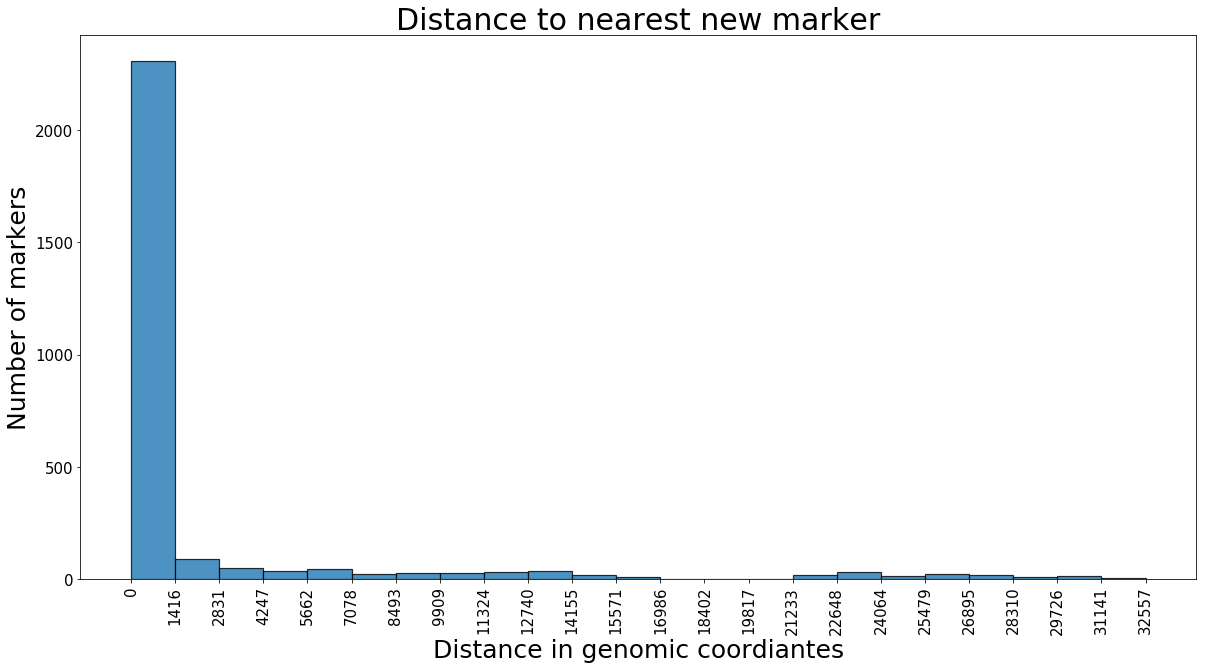

In [6]:
plt.figure(figsize=(20, 10))
counts, bins, patches = plt.hist(min_distance, alpha=0.8, bins=util.bincount_scott(min_distance), edgecolor="black", linewidth=1.2)
plt.title("Distance to nearest new marker", fontsize=30)
plt.xticks(bins, fontsize=15, rotation="vertical")
plt.xlabel("Distance in genomic coordiantes", fontsize=25)
plt.yticks(fontsize=15)
plt.ylabel("Number of markers", fontsize=25)
plt.savefig("./img/distance_to_new_markers.png", dpi=300)
plt.show()

In [7]:
pd.DataFrame(list(zip(np.round(bins), counts)), columns=["bin_left_border", "num_markers"]).to_csv("./img/distance_to_new_markers.csv", sep='\t', index=False)

In [9]:
%%time

predicted_rows = []
for old_marker, nearest_new in old_markers2new_markers.items():
    predicted_rows.append(np.hstack((old_marker, new_gen_df[short2full[nearest_new]].values + 1)))
predicted_df = pd.DataFrame(predicted_rows, columns=np.hstack(("SNP", new_gen_df["strain"])))
predicted_df.to_csv("./data/eQTLs/interpolated_genotypes.csv", sep='\t', index=False)


CPU times: user 4.38 s, sys: 80 ms, total: 4.46 s
Wall time: 4.58 s


In [10]:
namegroups = collections.Counter()
groups = old_gen_df.groupby("name") 
for name in set(old_gen_df["name"]): 
    namegroups[networks.convert_to_std(name)] = len(groups.get_group(name))
print(namegroups.most_common(15))

[('gKR08', 47), ('gOL01', 38), ('gKR07', 34), ('COS8', 23), ('ENA5', 16), ('YJL218W', 15), ('YER188W', 15), ('FLO10', 15), ('NAR005C', 14), ('HO', 14), ('PRM8', 14), ('YKR104W', 14), ('COS6', 14), ('REE1', 14), ('YOL162W', 13)]


In [157]:
for module_name, module_genes in tqdm(modules_dict.items()):
    module_graph = interactome_graph.subgraph(
        np.intersect1d(module_genes, interactome_graph.vs["name"])
    ).simplify()
    module_graph.vs.select(_degree=0).delete()
    if module_graph.vcount() > 0:
        qtls.plot_module_graph(
            destdir="./results/{}/new_eQTLs/".format(modules_type), 
            module_graph=module_graph, 
            qtl_df=eQTLs_df, 
            filename=module_name
        )

NameError: name 'modules_dict' is not defined

In [11]:
%%time

interpolated_eQTLs_df = pd.read_table("./data/eQTLs/interpolated_qtls.csv")
old_eQTLs_df = pd.read_table("./data/eQTLs/qtls.csv")
new_eQTLs_df = pd.read_table("./data/eQTLs/qtls_2018.csv")


CPU times: user 1.21 s, sys: 52 ms, total: 1.26 s
Wall time: 1.08 s


In [4]:
len(np.intersect1d(
    list(map(tuple, interpolated_eQTLs_df[["SNP", "gene"]].values)), 
    list(map(tuple, old_eQTLs_df[["SNP", "gene"]].values))
))

3672

In [12]:
old_marker2location = {name:i for i, name in enumerate(old_gen_df["RQTL_name"])}
with open("./data/genotypes/order_of_old_markers_in_genome.pkl", "wb") as pickle_file:
    pickle.dump(old_marker2location, pickle_file)

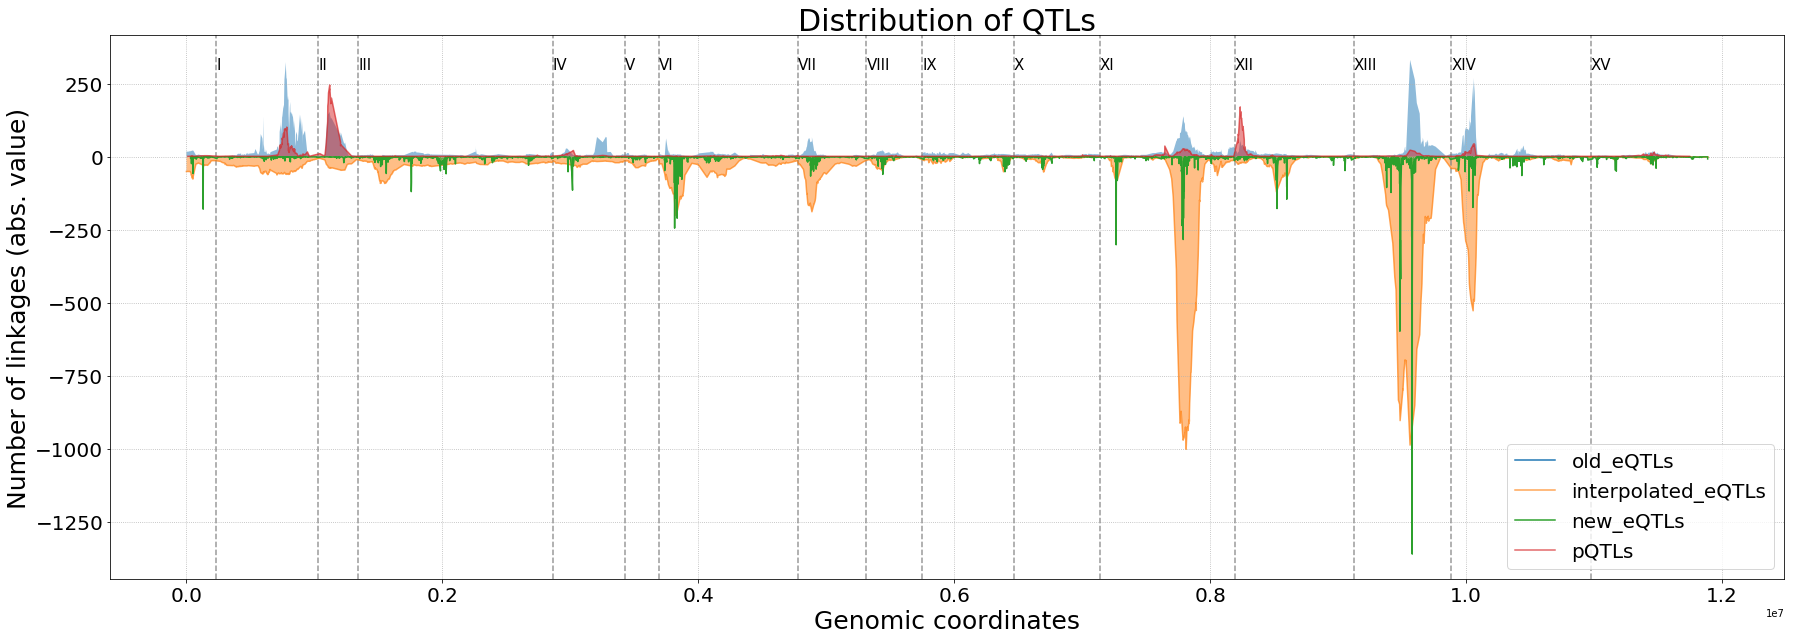

CPU times: user 2.47 s, sys: 8 ms, total: 2.48 s
Wall time: 2.47 s


In [29]:
%%time

reload(qtls)

old_eQTL_markers, old_eQTL_y = qtls.linkages2gencoords(old_eQTLs_df)
interpolated_eQTL_markers, interpolated_eQTL_y = qtls.linkages2gencoords(interpolated_eQTLs_df[interpolated_eQTLs_df["q.value"] <= 0.001])
new_eQTL_markers, new_eQTL_y = qtls.linkages2gencoords(new_eQTLs_df)
pQTL_markers, pQTL_y = qtls.linkages2gencoords(pQTLs_df)

old_eQTL_x = list(map(marker2coord.get, old_eQTL_markers))
interpolated_eQTL_x = list(map(marker2coord.get, interpolated_eQTL_markers))
new_eQTL_x = list(map(marker2coord.get, new_eQTL_markers))
pQTL_x = list(map(marker2coord.get, pQTL_markers))

plt.figure(figsize=(30, 10))
plt.title("Distribution of QTLs", fontsize=30)
for n in range(1, 16):
    plt.axvline(x=chromosome_ends[n], linestyle='--', color='grey', alpha=0.8)
    plt.text(chromosome_ends[n], 300, arabic2roman[n], fontsize=15)
plt.plot(list(map(marker2coord.get, old_eQTL_x)), old_eQTL_y, label="old_eQTLs")
plt.fill_between(old_eQTL_x, 0, old_eQTL_y, alpha=0.5)
plt.plot(interpolated_eQTL_x, -interpolated_eQTL_y, label="interpolated_eQTLs", alpha=0.7)
plt.fill_between(interpolated_eQTL_x, -interpolated_eQTL_y, 0, alpha=0.5)
plt.plot(new_eQTL_x, -new_eQTL_y, label="new_eQTLs", alpha=1)
plt.fill_between(new_eQTL_x, -new_eQTL_y, 0, alpha=0.7)
plt.plot(pQTL_x, pQTL_y, label="pQTLs", alpha=0.7)
plt.fill_between(pQTL_x, 0, pQTL_y, alpha=0.5)
plt.xlabel("Genomic coordinates", fontsize=25)
plt.ylabel("Number of linkages (abs. value)", fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20, loc=4)
plt.grid(linestyle="dotted")
plt.savefig("./img/linkages/qtls_combined.png", dpi=300)
plt.show()


In [13]:
new_marker2location = {name:i for i, name in enumerate(new_gen_df.columns[1:])}
with open("./data/genotypes/order_of_new_markers_in_genome.pkl", "wb") as pickle_file:
    pickle.dump(new_marker2location, pickle_file)

In [14]:
chr2marker = {n : list(map(tuple, old_chr2markpos[n][["RQTL_name", "position"]].values)) for n in range(1, 17)}
cnt = 1
for n in range(1, 17):
    chr2marker[n].extend([(new_gen_df.columns[cnt + i], position) for i, position in enumerate(new_chr2markpos[n])])
    cnt += len(new_chr2markpos[n])
    chr2marker[n].sort(key=lambda pair: pair[1])

In [15]:
marker_genomic_coordinates = sum([chr2marker[n] for n in range(1, 17)], [])
chromosome_ends = {}
offset, add = 0, 0
for n in range(1, 17):
    for i in range(len(chr2marker[n])):
        marker_genomic_coordinates[i + offset] = (
            marker_genomic_coordinates[i + offset][0], 
            marker_genomic_coordinates[i + offset][1] + add
        )
    offset += len(chr2marker[n])
    add += chr2marker[n][-1][1]
    chromosome_ends[n] = add 
    if n < 16:
        chromosome_ends[n] += add + chr2marker[n + 1][0][1] 
        chromosome_ends[n] /= 2
# for i in range(len(marker_genomic_coordinates)):
#     marker_genomic_coordinates[i] = (marker_genomic_coordinates[i][0], i)

In [16]:
with open("./data/genotypes/chromosome_endpoints.pkl", "wb") as pickle_file:
    pickle.dump(chromosome_ends, pickle_file)

In [17]:
with open("./data/genotypes/markers_by_chromosome.pkl", "wb") as pickle_file:
    pickle.dump(chr2marker, pickle_file)

In [18]:
marker2coord = collections.OrderedDict(marker_genomic_coordinates)
len(marker2coord)

44872

In [19]:
with open("./data/genotypes/order_of_markers.pkl", "wb") as pickle_file:
    pickle.dump(marker2coord, pickle_file)

In [176]:
len(sum([chr2marker[n] for n in range(1, 17)], [])) == len(marker_genomic_coordinates)

True